<img src='./img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='20%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./30_cams_eac4_retrieve.ipynb"><< 30 - CAMS EAC4 - Retrieve</a><span style="float:right;"><a href="./32_cams_eac4_exercise.ipynb">32 - CAMS EAC4 - Exercise >></a></span>

<div class="alert alert-block alert-warning">
<b>LOAD, BROWSE AND VISUALIZE</b></div>

# Copernicus Atmosphere Monitoring Service (CAMS) Global Reanalysis EAC4 

The Copernicus Atmopshere Monitoring Service (CAMS) provides consistent and quality-controlled information related to air pollution and health and greenhouse gases. CAMS data consist of `global forecasts and analyses`, `global reanalyses (EAC4)`, `fire emissions` and `greenhouse gas flux inversions`.

This notebooks provides an introduction to the CAMS global reanalysis (EAC4) data and as a smoke tracer the variable `Organic Matter Aerosol Optical Depth` is used. Alternatively, you can use `Total Aerosol Optical Depth` or `Total Column Carbon Monoxide` to monitor fires.

CAMS EAC4 data are available in either `GRIB` or `netCDF` format. Get more information in the [CAMS Reanalysis data documentation](https://confluence.ecmwf.int/display/CKB/CAMS%3A+Reanalysis+data+documentation).

#### Module outline:
* [1 - Load and browse organic matter aerosol optical depth (AOD) at 550nm](#load_browse)
* [2 - Bring longitude coordinates onto a (-180,180) grid](#shift)
* [3 - Retrieve the data variable organic matter AOD at 550nm as xarray DataArray](#data_retrieve)
* [4 - Visualize organic matter aerosol optical depth at 550nm](#visualize)
* [5 - Create a geographical subset for Australia](#subset)
* [6 - Animate organic matter AOD at 550nm changes over time](#animate)

<hr>

#### Load required libraries

In [126]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [96]:
from ipynb.fs.full.functions import visualize_pcolormesh, generate_geographical_subset

<hr>

### <a id='load_browse'></a>1. Load and browse `organic matter aerosol optical depth (AOD) at 550nm`

The organic matter aerosol optical depth at 550 nm data for this course is available in `netCDF`. You can use xarray's function `xr.open_dataset()` to open the netCDF file as xarray Dataset.

In [128]:
file = xr.open_dataset('./data/cams_eac4/20191225-31_cams_eac4.nc')
file


<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 56)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2019-12-25 ... 2019-12-31T21:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
    aod550     (time, latitude, longitude) float32 ...
    tcco       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-25 08:11:01 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

The data above has three dimensions (`latitude`, `longitude` and `time`) and three data variables, `omaod550`, `aod550` and `tcco`.

Let us inspect the coordinates of the file more in detail.

Below, you see that the data set consists of 56 time steps, ranging from 25 December 2019 00 UTC to 31 December 21 UTC in a three-hourly timestep.

In [129]:
file.time

<xarray.DataArray 'time' (time: 56)>
array(['2019-12-25T00:00:00.000000000', '2019-12-25T03:00:00.000000000',
       '2019-12-25T06:00:00.000000000', '2019-12-25T09:00:00.000000000',
       '2019-12-25T12:00:00.000000000', '2019-12-25T15:00:00.000000000',
       '2019-12-25T18:00:00.000000000', '2019-12-25T21:00:00.000000000',
       '2019-12-26T00:00:00.000000000', '2019-12-26T03:00:00.000000000',
       '2019-12-26T06:00:00.000000000', '2019-12-26T09:00:00.000000000',
       '2019-12-26T12:00:00.000000000', '2019-12-26T15:00:00.000000000',
       '2019-12-26T18:00:00.000000000', '2019-12-26T21:00:00.000000000',
       '2019-12-27T00:00:00.000000000', '2019-12-27T03:00:00.000000000',
       '2019-12-27T06:00:00.000000000', '2019-12-27T09:00:00.000000000',
       '2019-12-27T12:00:00.000000000', '2019-12-27T15:00:00.000000000',
       '2019-12-27T18:00:00.000000000', '2019-12-27T21:00:00.000000000',
       '2019-12-28T00:00:00.000000000', '2019-12-28T03:00:00.000000000',
       '2019-1

The latitude values have a 0.25 degrees resolution and have a global N-S coverage.

In [130]:
file.latitude

<xarray.DataArray 'latitude' (latitude: 241)>
array([ 90.  ,  89.25,  88.5 , ..., -88.5 , -89.25, -90.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
Attributes:
    units:      degrees_north
    long_name:  latitude

The longitude values have a 0.25 degrees resolution as well, but are on a [0,360] grid instead of [-180,180] grid. 

In [131]:
file.longitude

<xarray.DataArray 'longitude' (longitude: 480)>
array([  0.  ,   0.75,   1.5 , ..., 357.75, 358.5 , 359.25], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
Attributes:
    units:      degrees_east
    long_name:  longitude

### <a id='shift'></a>2. Bring longitude coordinates onto a [-180,180] grid

You can assign new values to coordinates in an xarray Dataset. You can do so with the `assign_coords()` function, which you can apply onto an xarray Dataset. With the code below, you shift your longitude grid from [0,360] to [-180,180]. At the end, you sort the longitude values in an ascending order.

In [132]:
file_assigned = file.assign_coords(longitude=(((file.longitude + 180) % 360) - 180)).sortby('longitude')
file_assigned

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 56)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2019-12-25 ... 2019-12-31T21:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 0.0010485649 ... 0.012378216
    aod550     (time, latitude, longitude) float32 0.006456852 ... 0.030357838
    tcco       (time, latitude, longitude) float32 0.0008804556 ... 0.00024561584
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-25 08:11:01 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

A quick check of the longitude coordinates of the new xarray Dataset shows you that the longitude values range now between [-180, 180].

In [133]:
file_assigned.longitude

<xarray.DataArray 'longitude' (longitude: 480)>
array([-180.  , -179.25, -178.5 , ...,  177.75,  178.5 ,  179.25],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25

### <a id='data_retrieve'></a>3. Retrieve the data variable `organic matter AOD at 550nm` as xarray DataArray

Let us store the data variable `organic matter AOD at 550nm` as xarray DataArray with the name `om_aod`.

In [134]:
om_aod = file_assigned.omaod550
om_aod

<xarray.DataArray 'omaod550' (time: 56, latitude: 241, longitude: 480)>
array([[[0.001049, 0.001049, ..., 0.001049, 0.001049],
        [0.001325, 0.001325, ..., 0.001325, 0.001325],
        ...,
        [0.005608, 0.005608, ..., 0.005608, 0.005608],
        [0.011135, 0.011135, ..., 0.011135, 0.011135]],

       [[0.001187, 0.001187, ..., 0.001187, 0.001187],
        [0.001049, 0.001049, ..., 0.001049, 0.001049],
        ...,
        [0.00699 , 0.00699 , ..., 0.00699 , 0.00699 ],
        [0.011273, 0.011273, ..., 0.011273, 0.011273]],

       ...,

       [[0.002569, 0.002569, ..., 0.002569, 0.002569],
        [0.002569, 0.00243 , ..., 0.002569, 0.002569],
        ...,
        [0.007957, 0.007957, ..., 0.007957, 0.007957],
        [0.015141, 0.015141, ..., 0.015141, 0.015141]],

       [[0.002569, 0.002569, ..., 0.002569, 0.002569],
        [0.002154, 0.002154, ..., 0.002154, 0.002154],
        ...,
        [0.006575, 0.006575, ..., 0.006575, 0.006575],
        [0.012378, 0.012378, ...

Above, you see that the variable `om_aod` has two attributs, `units` and `long_name`. Let us define variables for those attributes. The variables can be used for visualizing the data.

In [84]:
long_name = om_aod.long_name
units = om_aod.units

Let us do the same for the coordinates `longitude` and `latitude`.

In [47]:
latitude = om_aod.latitude
longitude = om_aod.longitude

### <a id='visualize'></a>4. Visualize `organic matter aerosol optical depth at 550nm`

Let us visualize the dataset. You can use the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh), which makes use of matploblib's function `pcolormesh` and the Cartopy library.

With `?visualize_pcolormesh` you can open the function's docstring to see what keyword arguments are needed to prepare your plot.

In [11]:
?visualize_pcolormesh

You can make use of the variables we have defined above:
- `units`
- `long_name`
- `latitude`
- `longitude`

Additionally, you can specify the color scale and minimum and maxium data values.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fddba9f52e8>)

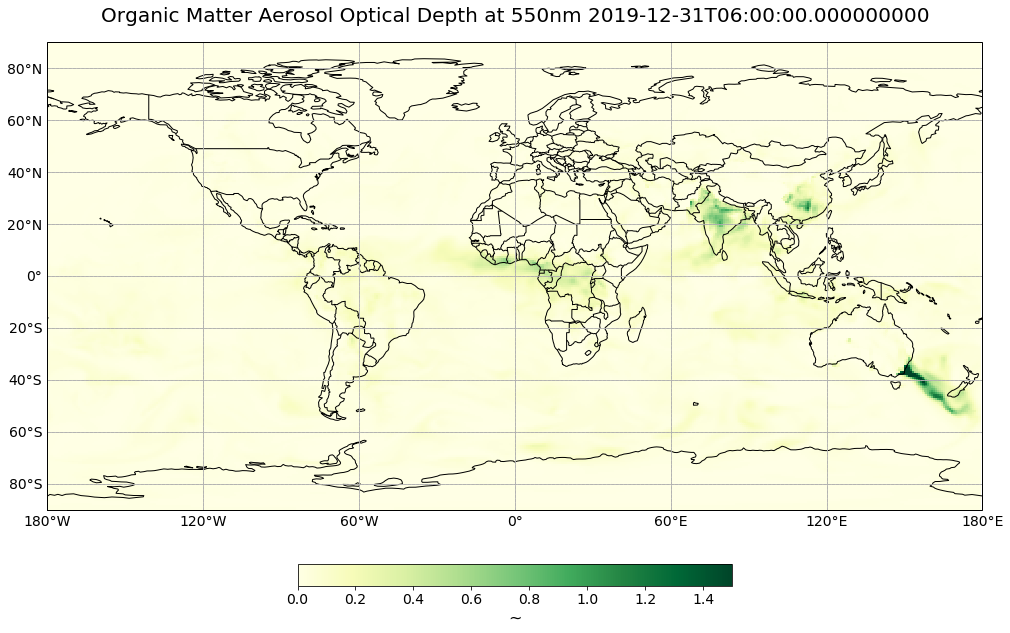

In [115]:
visualize_pcolormesh(
    om_aod[50,:,:],
    longitude,
    latitude,
    ccrs.PlateCarree(),
    'YlGn',
    units,
    long_name + ' ' + str(om_aod[50,:,:].time.data),
    0, 1.5,
    -180,180,-90,90,
    log=False,
    set_global=True
    )

<br>

### <a id='subset'></a>5. Create a geographical subset for Australia

The map above shows organic matter of Aerosol Optical Depth at 550nm globally. Let us create a geographical subset for Australia, in order to better analyse the Australian wildfires.

For geographical subsetting, you can use the function [generate_geographical_subset](./functions.ipynb#generate_geographical_subset). You can use `?generate_geographical_subset` to open the docstring in order to see the function's keyword arguments.

In [99]:
?generate_geographical_subset

Define the bounding box information

In [100]:
latmin = -70
latmax = 10
lonmin = 100
lonmax = 179.5

Now, let us apply the function [generate_geographical_subset](./functions.ipynb#generate_geographcial_subset) to subset the `om_aod` DataArray. Let us call the new DataArray `om_aod_subset`.

In [111]:
om_aod_subset = generate_geographical_subset(om_aod, latmin, latmax, lonmin, lonmax)
om_aod_subset

<xarray.DataArray 'omaod550' (time: 56, latitude: 107, longitude: 106)>
array([[[0.14598 , 0.182317, ..., 0.057004, 0.055346],
        [0.117657, 0.142664, ..., 0.06336 , 0.059353],
        ...,
        [0.020806, 0.023569, ..., 0.035451, 0.039043],
        [0.023431, 0.02578 , ..., 0.047609, 0.052168]],

       [[0.152888, 0.175271, ..., 0.051201, 0.048438],
        [0.127881, 0.130506, ..., 0.0588  , 0.053826],
        ...,
        [0.025918, 0.029372, ..., 0.032826, 0.033655],
        [0.024813, 0.027438, ..., 0.037247, 0.042635]],

       ...,

       [[0.219068, 0.19931 , ..., 0.004917, 0.004917],
        [0.149296, 0.141835, ..., 0.005055, 0.004917],
        ...,
        [0.004641, 0.004364, ..., 0.005055, 0.005608],
        [0.003536, 0.003536, ..., 0.004779, 0.005332]],

       [[0.174856, 0.161592, ..., 0.004917, 0.004779],
        [0.116414, 0.094031, ..., 0.004917, 0.004779],
        ...,
        [0.004088, 0.003812, ..., 0.006299, 0.00699 ],
        [0.003812, 0.003812, ...

Let us visualize the subsetted DataArray again. This time, you set the `set_global` kwarg to `False` and you specify the longitude and latitude bounds specified above.

Additionally - in order to have the time information as part of the title, we add the string of the datatime information to the `long_name` variable: `long_name + ' ' + str(om_aod_subset[50,:,:].time.data)`.

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fddba9f5c18>)

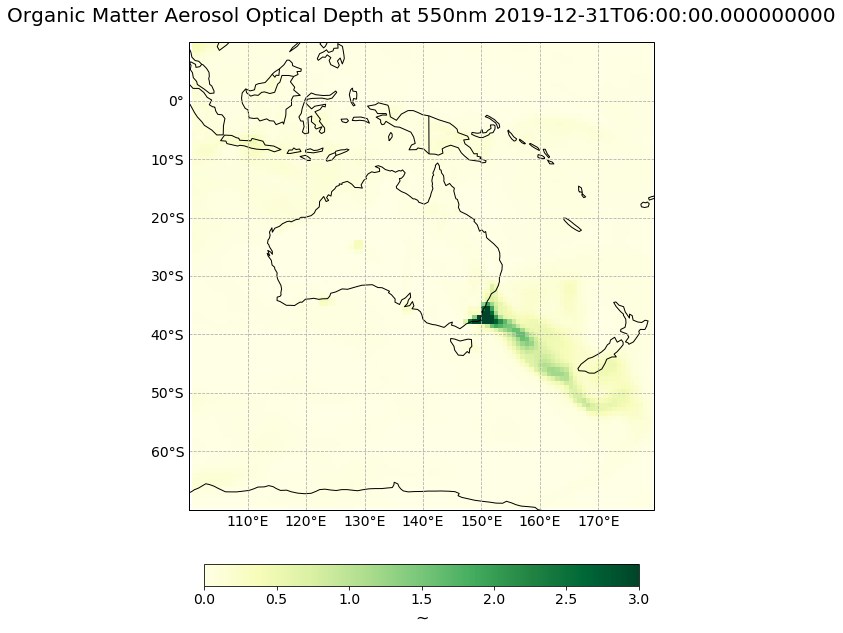

In [114]:
visualize_pcolormesh(
    om_aod_subset[50,:,:],
    om_aod_subset.longitude,
    om_aod_subset.latitude,
    ccrs.PlateCarree(),
    'YlGn',
    units,
    long_name + ' ' + str(om_aod_subset[50,:,:].time.data),
    0, 3,
    lonmin,lonmax,latmin,latmax,
    log=False,
    set_global=False
    )

<br>

### <a id='animate'></a>6. Animate `organic matter AOD at 550nm` changes over time

In the last step, we would like to animate the `organic matter AOD at 550nm` in order to see how the trace gas develops over a period of seven days, from 25th to 31st December 2019.

You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [1]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(om_aod_subset[0,:,:],om_aod_subset.longitude, om_aod_subset.latitude,ccrs.PlateCarree(), 
                        'YlGn', '-',long_name + ' '+ str(om_aod_subset.time[0].data), 0,1.5, lonmin, lonmax, latmin , latmax, log=False,set_global=False)

frames = 56

def draw(i):
    img = plt.pcolormesh(om_aod_subset.longitude, om_aod_subset.latitude, om_aod_subset[i,:,:], 
                        cmap='YlGn', transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=1.5)
    ax.set_title(long_name + ' '+ str(om_aod_subset.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

NameError: name 'visualize_pcolormesh' is not defined

#### Play the animation video as HTML5 video

In [125]:
HTML(ani.to_html5_video())

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./30_cams_eac4_retrieve.ipynb"><< 30 - CAMS EAC4 - Retrieve</a><span style="float:right;"><a href="./32_cams_eac4_exercise.ipynb">32 - CAMS EAC4 - Exercise >></a></span>

<hr>

<p><img src='./img/all_partners_wekeo.png' align='left' alt='Logo EU Copernicus' width='100%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on Github</a>